# 데이터셋 분할

## 실습 개요

데이터셋 분할

1) 실습 목적
- 이번 실습에서는 다양한 데이터셋 분할 방법을 탐색하고 이를 LightGBM에 적용해 봅니다.

2) 수강 목표
- 다양한 데이터 분할을 데이터에 적용할 수 있습니다.
- 분할된 데이터를 활용해 LightGBM을 학습할 수 있습니다.

### 실습 목차

* **1. 실습 데이터 준비**
  * 데이터 불러오기 및 전처리
* **2. 데이터 분할**
  * Holdout
  * K-Fold
  * Stratified K-Fold
  * Group K-Fold
  * Time-Series Split

### 데이터셋 개요
* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)

### 환경 설정
- **패키지 설치 및 임포트**

In [1]:
!pip install scikit-learn==1.3.0
!pip install numpy==1.23.5
!pip install lightgbm==4.0.0
!pip install gdown==4.6.6
!pip install pandas==1.5.3

  Obtaining dependency information for scikit-learn==1.3.0 from https://files.pythonhosted.org/packages/18/36/60b58b6199547b7b46be03e05508d053162fbce146639bfc65609fa49b23/scikit_learn-1.3.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 6.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 5.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cytho

In [28]:
# 계산
import numpy as np
import time
# 전처리
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit

# 평가
from sklearn.metrics import mean_squared_error

# 모델링
import lightgbm as lgb

from sklearn.ensemble import GradientBoostingRegressor

# 출력 및 시각화
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# 데이터셋 로드 및 정제
import pandas as pd
import joblib
import gdown

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

## 1. 실습 데이터 준비

```
💡 목차 개요 : 데이터 분할과 LightGBM 학습을 위한 데이터를 준비합니다.
```
- **1-1 데이터 불러오기 및 전처리**

### 1-1. 데이터 불러오기 및 전처리

#### 📝 설명 : (1-1)
* 데이터 분할을 진행하기에 앞서 학습에 사용 될 데이터를 불러옵니다.
* 데이터의 구성을 확인하고, 학습에 알맞는 전처리를 진행합니다.


#### 👨‍💻 코드 : (1-1)

> 이번 실습에서는 금융 도메인의 주가 데이터셋(OHLCV)을 이용합니다.

In [6]:
# # OHLCV 데이터셋 불러오기
# file_id = "1xa3PwhjxN3mUEz_YrczQi2TVImReIL-X"
# OHLCV_file = "OHLCV.parquet"
# gdown.download(f"https://drive.google.com/uc?id={file_id}", OHLCV_file)
# OHLCV_data = pd.read_parquet(OHLCV_file)

# # 날짜는 데이터셋의 index로 되어 있습니다.
# # .loc을 통해서 날짜 범위를 지정해줍시다.
# OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# # 상장법인정보 파일도 불러오도록 하겠습니다.
# file_id = "16Uzp-FWMNY5aeohcHGunVYwobia7up5W"
# company_file = "Company.parquet"
# gdown.download(f"https://drive.google.com/uc?id={file_id}", company_file)
# company_data = pd.read_parquet(company_file)

In [4]:
# OHLCV 데이터셋 불러오기
file_path = "/Users/myeongjinlee/Desktop/UPSTAGE AI/ml advanced"
OHCLV_file = "[ML Advanced] 실습용 데이터 셋 - OHCLV.parquet"

OHLCV_data = pd.read_parquet(f"{file_path}/{OHCLV_file}")

# 날짜는 데이터셋의 index로 되어 있습니다.
# .loc을 통해서 날짜 범위를 지정해줍시다.
OHLCV_data = OHLCV_data.sort_index()
OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
company_file = "[ML Advanced] 실습용 데이터 셋 - Company.parquet"
company_data =  pd.read_parquet(f"{file_path}/{company_file}")

In [5]:
# OHLCV은 종목별 주가와 관련된 정보를 나타내는 데이터셋입니다.
display(OHLCV_data.head(10))

# 상장법인정보 데이터셋입니다.
display(company_data.head(10))

,Open,High,Low,Close,Volume,Change,code
2020-01-02,7037.0,7123.0,7018.0,7106.0,13986.0,0.009518,001530
2020-01-02,31400.0,32350.0,31100.0,32100.0,75206.0,0.033816,003350
2020-01-02,7300.0,7450.0,7270.0,7340.0,60800.0,0.009629,005870
2020-01-02,1165.0,1180.0,1160.0,1175.0,117291.0,0.008584,006340
2020-01-02,95100.0,95200.0,91800.0,91900.0,250460.0,-0.035677,010950
2020-01-02,77800.0,78900.0,77200.0,77700.0,3389.0,-0.001285,02826K
2020-01-02,769000.0,771000.0,757000.0,770000.0,1023.0,-0.001297,051905
2020-01-02,11600.0,11750.0,11400.0,11400.0,1549105.0,-0.017241,316140
2020-01-02,427932.0,434356.0,420520.0,423485.0,109563.0,-0.010392,207940
2020-01-02,90400.0,92300.0,89100.0,91900.0,20863.0,0.027964,090435


,company,code,industry,products,listing_date,closing_month,region
0,시지트로닉스,429270,반도체 제조업,특화반도체 소자,2023-08-03,12월,전라북도
1,에피바이오텍,446440,자연과학 및 공학 연구개발업,탈모 치료제,2023-07-31,12월,인천광역시
2,조선내화,462520,"내화, 비내화 요업제품 제조업",내화 요업제품,2023-07-28,12월,전라남도
3,에이엘티,172670,반도체 제조업,반도체 테스트 및 패키징(반도체 후공정),2023-07-27,12월,충청북도
4,유안타제14호스팩,450940,금융 지원 서비스업,금융 지원 서비스,2023-07-27,12월,서울특별시
5,파로스아이바이오,388870,자연과학 및 공학 연구개발업,PHI-101 급성골수성백혈병 치료제 및 재발성난소암 치료제,2023-07-27,12월,경기도
6,길교이앤씨,456700,"건축기술, 엔지니어링 및 관련 기술 서비스업",강합성 라멘교,2023-07-26,12월,경상북도
7,버넥트,438700,소프트웨어 개발 및 공급업,산업용 XR 솔루션,2023-07-26,12월,서울특별시
8,뷰티스킨,406820,기타 화학제품 제조업,"화장품 제조, 브랜드, 유통 사업",2023-07-24,12월,인천광역시
9,SK증권제9호스팩,455910,금융 지원 서비스업,기업인수목적회사,2023-07-21,12월,서울특별시


- 이번 실습을 시작하기 전에 우리는 크게 두 가지 성향의 파생 변수를 만들고 시작할거에요.
- 첫 번째는 금융 도메인 지식에 기반해서 파생 변수를 만들고 시작할게요!
- 자칫 어려울수도 있으나, 주가 관련한 금융 도메인에서는 이런 파생 변수가 존재하는걸 인지만하시고 넘어가시면 됩니다.

In [7]:
# 데이터셋의 컬럼을 확인합니다.

display(f"데이터셋 컬럼: {tuple(OHLCV_data.columns)}")

"데이터셋 컬럼: ('Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'code')"

In [8]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"])
OHLCV_data.reset_index(drop=True, inplace=True)

# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")

OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)

# 파생 변수1 - 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]
# 파생 변수2 - 종목의 대푯값인 평균 가격를 구합시다.
OHLCV_data["AveragePrice"] = (OHLCV_data["Open"] + OHLCV_data["High"] + OHLCV_data["Low"] - OHLCV_data["Close"]) / 4
# 파생 변수3 - 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
OHLCV_data['PriceDirection'] = OHLCV_data.apply(lambda row: 1 if row['Close'] > row['Open'] else -1, axis=1)
# 파생 변수4 - 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = OHLCV_data.groupby('code')['Close'].transform(lambda x: x.pct_change() * 100)
# 파생 변수5 - 장기, 중기, 단기 이동평균을 파생변수로 추가합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

# 파생 변수6 - 볼린저 밴드(Bolinger bands)는 이동 평균을 기준으로 상한, 하한 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2
std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())
# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

# 파생 변수7 - MACD (Moving Average Convergence & Divergence)는 추가 추세의 힘과 방향성을 파악하여 매매신호를 잡는 목적으로 사용됩니다.
OHLCV_data['ShortEMA'] = OHLCV_data["Close"].ewm(span=12, adjust=False).mean()
OHLCV_data['LongEMA'] = OHLCV_data["Close"].ewm(span=26, adjust=False).mean()
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 두 번째는 상장법인정보를 기반으로 만들어볼거에요!
- 업종(industry), 주요 제품(products), 상장일(listing_date) 등을 결합해서 새로운 파생 변수를 만들어보도록 하겠습니다.

In [9]:
# 파생 변수8 - OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.
# 일별 시가의 평균, 중앙값
open_stats = OHLCV_data.groupby(["Date", "industry"])["Open"].agg(["mean", "median"])
open_stats.columns = ["OpenMean", "OpenMedian"]
OHLCV_data = pd.merge(OHLCV_data, open_stats, how="inner", on=["industry", "Date"])
# 일별 고가의 평균, 중앙값
high_stats = OHLCV_data.groupby(["Date", "industry"])["High"].agg(["mean", "median"])
high_stats.columns = ["HighMean", "HighMedian"]
OHLCV_data = pd.merge(OHLCV_data, high_stats, how="inner", on=["industry", "Date"])
# 일별 저가의 평균, 중앙값
low_stats = OHLCV_data.groupby(["Date", "industry"])["Low"].agg(["mean", "median"])
low_stats.columns = ["LowMean", "LowMedian"]
OHLCV_data = pd.merge(OHLCV_data, low_stats, how="inner", on=["industry", "Date"])
# 일별 종가의 평균, 중앙값
close_stats = OHLCV_data.groupby(["Date", "industry"])["Close"].agg(["mean", "median"])
close_stats.columns = ["CloseMean", "CloseMedian"]
OHLCV_data = pd.merge(OHLCV_data, close_stats, how="inner", on=["industry", "Date"])
# 일별 거래량의 평균, 중앙값
volume_stats = OHLCV_data.groupby(["Date", "industry"])["Volume"].agg(["mean", "median"])
volume_stats.columns = ["VolumeMean", "VolumeMedian"]
OHLCV_data = pd.merge(OHLCV_data, volume_stats, how="inner", on=["industry", "Date"])

# 파생 변수 9 - 시간관련 파생 변수
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.
# Date컬럼 나누기
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day
# listing_date컬럼 나누기
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

- 학습을 위해서 범주형 변수를 인코딩 하는 작업을 하겠습니다.
- Label Encoding, Frequency Encdoing, Target Encoding

In [10]:
# Label Encoding을 진행합니다.
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
label_encoder = LabelEncoder()

OHLCV_data["LEncodedIndustry"] = label_encoder.fit_transform(OHLCV_data["industry"])
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])
OHLCV_data["LEncodedCode"] = label_encoder.fit_transform(OHLCV_data["code"])

# Frequency Encoding을 진행합니다.
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

# Target Encoding을 진행합니다.
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

- 마지막으로 결측치와 학습에 불필요한 컬럼들은 모두 제거하겠습니다.

In [11]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

OHLCV_data.drop([
    "company", "industry",
    "products", "listing_date", "closing_month",
    "region", "code"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

In [12]:
# 데이터의 날짜 범위를 알아보도록 하겠습니다.

display(f"데이터셋 날짜 범위: {OHLCV_data['Date'].min()} ~ {OHLCV_data['Date'].max()}")

'데이터셋 날짜 범위: 2020-06-25 00:00:00 ~ 2023-07-28 00:00:00'

In [13]:
# 마지막 1개월을 기준으로 학습/테스트 세트를 분리합니다.
train_data = OHLCV_data.loc[OHLCV_data["Date"] < "2023-07-01"].reset_index(drop=True)
test_data = OHLCV_data.loc[OHLCV_data["Date"] >= "2023-07-01"].reset_index(drop=True)

# 이후 time series split에서 사용하기 위해 날짜에 대한 정보를 별도로 저장해둡니다.
date_list = (train_data['Date'])

# Date 컬럼은 이제 필요가 없으니 제거하겠습니다.
train_data.drop("Date", axis=1, inplace=True)
test_data.drop("Date", axis=1, inplace=True)

display(f"학습 데이터셋 : {len(train_data)} 개")
display(f"테스트 데이터셋 : {len(test_data)} 개")

'학습 데이터셋 : 546452 개'

'테스트 데이터셋 : 15241 개'

In [14]:
# input값들과 target값을 구분합니다.
target_col = "Target" # 다음날의 종가 (Close)
input_cols = list(train_data.columns)
input_cols.remove(target_col)

display(f"Input Featrue : {input_cols}")
display(f"Target : {target_col}")

"Input Featrue : ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn', 'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d', 'MovingAverage120d', 'LowerBollingerBand', 'UpperBollingerBand', 'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean', 'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian', 'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay', 'ListingDateYear', 'ListingDateMonth', 'ListingDateDay', 'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts', 'LEncodedRegion', 'LEncodedCode', 'FEncodedIndustry', 'TEncodedIndustry']"

'Target : Target'

In [15]:
# 학습과 테스트세트에서 입력값과 목표값을 분리합니다.

X_train = train_data[input_cols]
Y_train = train_data[target_col]

X_test = test_data[input_cols]
Y_test = test_data[target_col]

display("학습에 사용할 최종 데이터의 형태는 아래와 같습니다.")
display(f"Train Input : {X_train.shape}")
display(f"Train Target : {Y_train.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Test Target : {Y_test.shape}")

'학습에 사용할 최종 데이터의 형태는 아래와 같습니다.'

'Train Input : (546452, 42)'

'Train Target : (546452,)'

'Test Input : (15241, 42)'

'Test Target : (15241,)'

## 2. 데이터 분할

```
💡 목차 개요 : 다양한 데이터 분할을 적용해봅니다.
```
- **2-1 Holdout**
- **2-2 K-Fold**
- **2-3 Stratified K-Fold**
- **2-4 Group K-Fold**
- **2-5 Time-Series Split**

### 2-1 Holdout


#### 📝 설명 : (2-1)

- 가장 기본적인 분할 방법입니다.
- 전체 데이터를 8:2 등과 같이 일정 비율로 분리하는 기법으로, 랜덤하게 분리하거나 경우에 따라 가장 최근 20%를 검증데이터로 사용합니다.

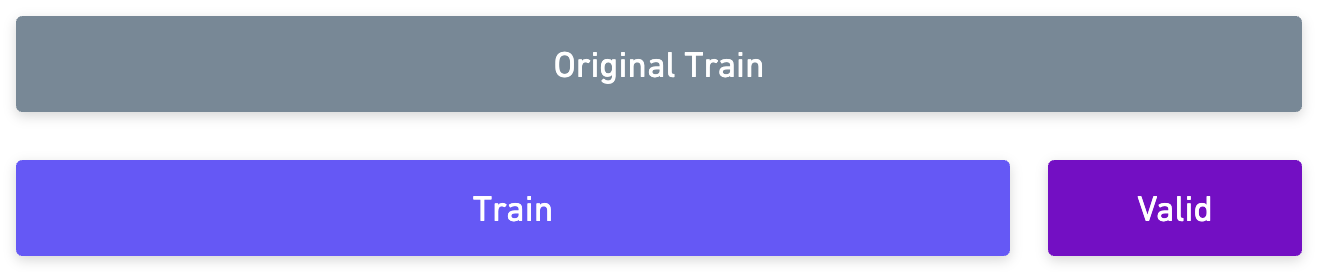

#### 👨‍💻 코드 : (2-1)


In [16]:
# 학습데이터를 학습/검증 데이터로 분리합니다.
# Sklearn의 Holdout을 이용해 랜덤으로 8:2로 분리합니다.

holdout_X_train, holdout_X_valid, holdout_Y_train, holdout_Y_valid = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True) # default shuffle : True

display(f"Train Input : {holdout_X_train.shape}")
display(f"Train Target : {holdout_Y_train.shape}")
display(f"Valid Input : {holdout_X_valid.shape}")
display(f"Valid Target : {holdout_Y_valid.shape}")
display(f"Test Input : {X_test.shape}")
display(f"Valid Target : {Y_test.shape}")

'Train Input : (437161, 42)'

'Train Target : (437161,)'

'Valid Input : (109291, 42)'

'Valid Target : (109291,)'

'Test Input : (15241, 42)'

'Valid Target : (15241,)'

In [17]:
# LightGBM을 선언합니다.
# 학습은 총 1000번을 반복합니다.
# 데이터셋 분할에 따른 성능비교를 위해 별도의 Parameter 튜닝은 적용하지 않고 기본값을 사용합니다.

gbm = lgb.LGBMRegressor(n_estimators=1000)

In [19]:
# 학습을 진행합니다.
# 비교를 위해 %%time을 이용해 학습시간을 측정합니다.


gbm.fit(holdout_X_train, holdout_Y_train,                                                  # 학습 데이터를 입력합니다.
        eval_set=[(holdout_X_train, holdout_Y_train), (holdout_X_valid, holdout_Y_valid)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                 # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                          # 매 iteration마다 학습결과를 출력합니다.
)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8143
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 41952.472174
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34828.1	training's l2: 1.21299e+09	valid_1's rmse: 34154.8	valid_1's l2: 1.16655e+09
[20]	training's rmse: 12752.4	training's l2: 1.62624e+08	valid_1's rmse: 12528	valid_1's l2: 1.5695e+08
[30]	training's rmse: 5618.21	training's l2: 3.15642e+07	valid_1's rmse: 5640.39	valid_1's l2: 3.1814e+07
[40]	training's rmse: 3750.93	training's l2: 1.40694e+07	valid_1's rmse: 3953.02	valid_1's l2: 1.56264e+07
[50]	training's rmse: 3308.17	training's l2: 1.0944e+07	valid_1's rmse: 3603.27	valid_1's l2: 1.29836

LGBMRegressor(n_estimators=1000)

In [20]:
# 학습한 모델을 저장합니다.

joblib.dump(gbm, 'holdout_gbm.pkl')

['holdout_gbm.pkl']

In [21]:
# 저장한 모델을 불러옵니다.

gbm_trained = joblib.load('holdout_gbm.pkl')

In [22]:
# 불러온 모델을 통해 추론을 진행합니다.
# 이후, Test set에 대한 rmse를 측정합니다.

predicts = gbm_trained.predict(X_test)
RMSE = mean_squared_error(Y_test, predicts)**0.5
print(f"Test rmse : {RMSE}")

Test rmse : 3496.5261242582365


- Holdout 학습의 최종결과는 아래와 같습니다.
  - Training Time : 29.9s
  - Train RMSE : 2097.48
  - Valid RMSE : 3015.71
  - Test RMSE : 3487.40

- Valid RMSE와 Test RMSE의 차이가 크게 나는 모습을 확인할 수 있습니다.
- Random하게 Train/valid의 Split을 진행했기에 Test셋에 대해서는 적합하지 않은 Valid셋이 구성되었다는 점을 알 수 있습니다.

#### 📚 자료
- [train_test_split - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

### 2-2 K-Fold


#### 📝 설명 : (2-2)

- K번의 Holdout으로 데이터를 분리하는 방법입니다.
- K-1개를 학습 세트로, 1개를 검증 세트로 사용하며 동일한 Fold가 없도록 해야합니다.
- 최적의 학습,검증 Fold셋을 찾아내거나 모델들의 결과를 앙상블해서 사용합니다

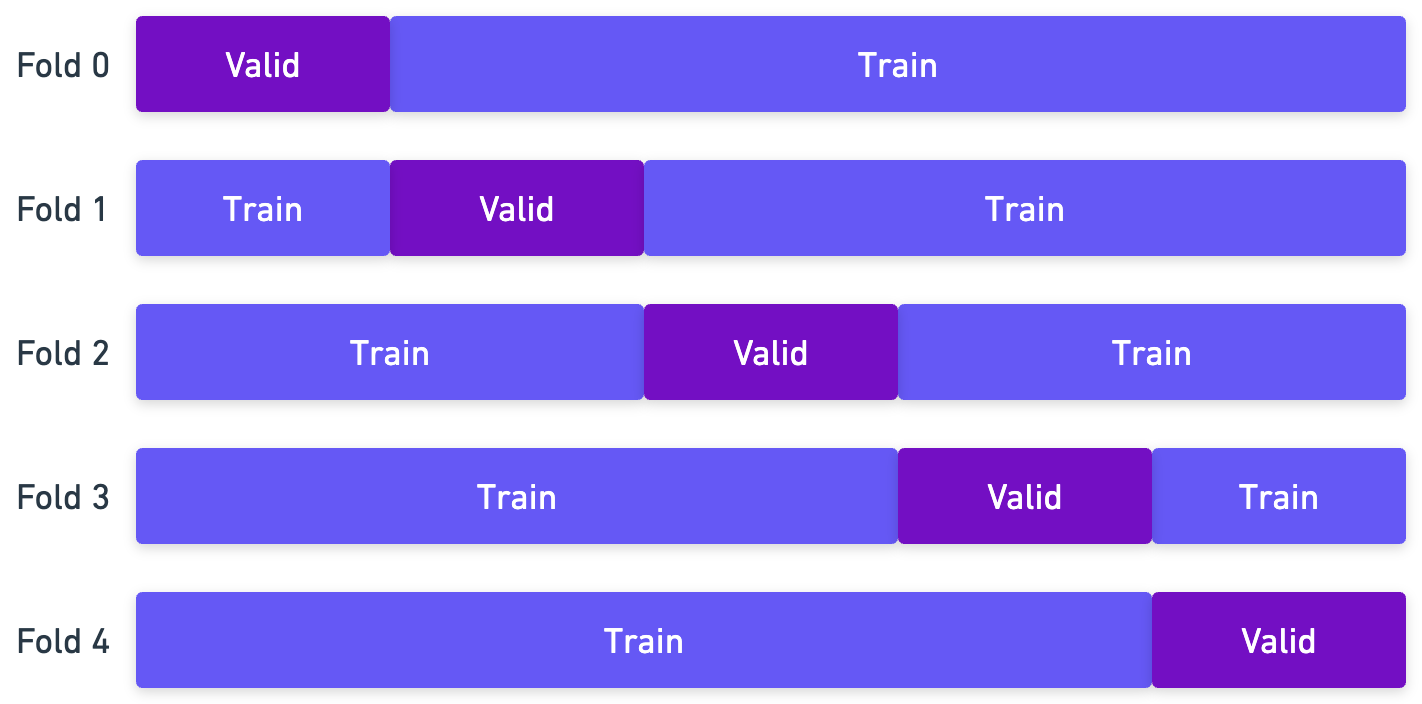


#### 👨‍💻 코드 : (2-2)

In [23]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [24]:
# Kfold 함수를 선언합니다.
kf = KFold(n_splits=5)

Fold 0 :
  Train : index=[109291 109292 109293 109294 109295]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[109291 109292 109293 109294 109295]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[218582 218583 218584 218585 218586]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[327872 327873 327874 327875 327876]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[437162 437163 437164 437165 437166]...


<Axes: title={'center': 'K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

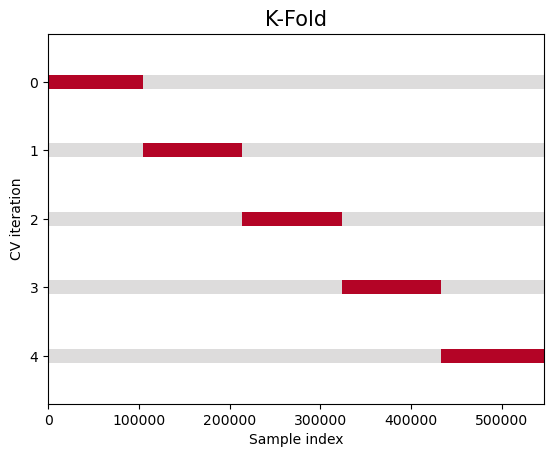

In [25]:
# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')

In [26]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x286dcb0a0>

- Kfold적용 시, 결과는 generator object로 반환됩니다.
- python generator는 iterator를 생성해주는 함수입니다.
- 즉, loop를 통해 불러올때 값을 확인할 수 있습니다.

In [30]:
# 학습을 진행합니다.

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    print(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8121
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 38976.098026
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 31845.1	training's l2: 1.01411e+09	valid_1's rmse: 63607.3	valid_1's l2: 4.04588e+09
[20]	training's rmse: 11660.8	training's l2: 1.35975e+08	valid_1's rmse: 45851.2	valid_1's l2: 2.10233e+09
[30]	training's rmse: 5152.95	training's l2: 2.65529e+07	valid_1's rmse: 41219.2	valid_1's l2: 1.69902e+09
[40]	training's rmse: 3454.61	training's l2: 1.19343e+07	valid_1's rmse: 39774.1	valid_1's l2: 1.58198e+09
[50]	training's rmse: 3061.06	training's l2: 9.37008e+06	val

In [31]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'kfold0_gbm.pkl - Test rmse : 3567.055964571741'

'kfold1_gbm.pkl - Test rmse : 4234.990844879663'

'kfold2_gbm.pkl - Test rmse : 6731.210851177929'

'kfold3_gbm.pkl - Test rmse : 3675.4194257296185'

'kfold4_gbm.pkl - Test rmse : 3807.7996619078413'

'최종 Test rmse : 3495.298405029362'

In [32]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.

top_3_files = ["kfold1_gbm.pkl", "kfold3_gbm.pkl", "kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'kfold1_gbm.pkl - Test rmse : 4234.990844879663'

'kfold3_gbm.pkl - Test rmse : 3675.4194257296185'

'kfold4_gbm.pkl - Test rmse : 3807.7996619078413'

'최종 Test rmse : 3430.6729252664813'

- K-Fold적용 시, 모든 Fold를 사용하는 것 보다 Valid RMSE 기준으로 Top3 Fold를 사용하는 것이 더 좋은 모습입니다.

- Kfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 40.5s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 5290.11
  - Test RMSE(Top3) : 3243.60
  - Test RMSE(Top1) : 3447.76

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60

#### 📚 자료
- [KFold - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

### 2-3. Stratifiend K-Fold


#### 📝 설명 : (2-3)

- K개의 Fold를 구성하는 방법은 K-Fold와 동일하지만, Fold별 Y의 비율도 동일하게 하는 분할 방법입니다.
- 데이터의 양이 적거나 불균형이 심한 데이터에 대해 K-Fold적용 시 분포가 크게 달라지는 현상을 방지할 수 있습니다.


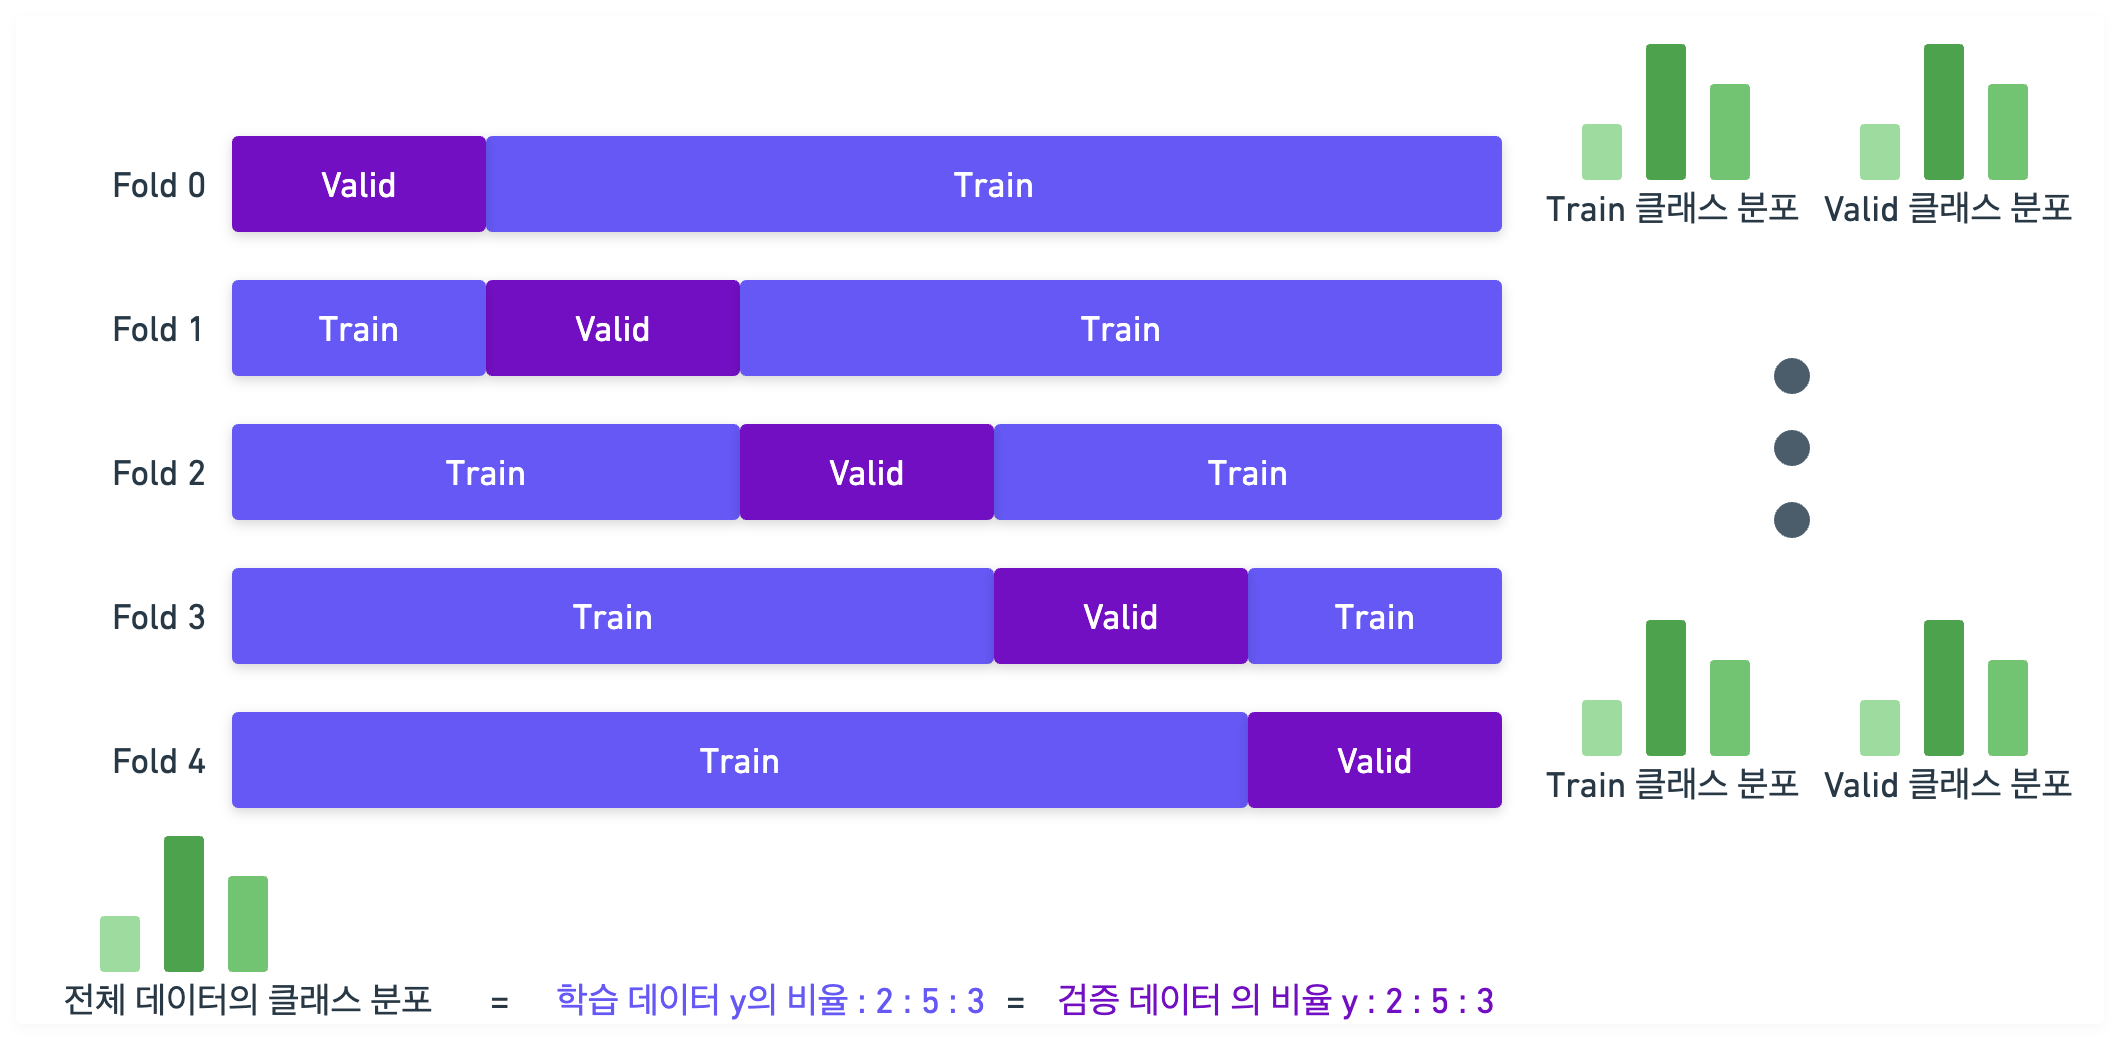

#### 👨‍💻 코드 : (2-3)


In [33]:
# Stratified Kfold 함수를 선언합니다.
kf = StratifiedKFold(n_splits=5)

In [34]:
# Target값을 기준으로 분포에 따라 1000등분합니다.
# Stratified KFold에서 각 구간을 기준으로 Y의 비율을 동일하게 가져가게 됩니다.
# 0, ... 9 = 0 / 10, ..., 19 = 1 / ..
cut_Y_train = pd.cut(Y_train,
                     1000, # 데이터를 최소 최대 구간으로 1000등분 합니다.
                     labels=False)

Fold 0 :
  Train : index=[2865 2953 3011 3039 3066]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[2953 3011 3039 3179 3208]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[2865 3291 3407 3464 3629]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[3262 3490 3545 3572 4657]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[3066 3124 3321 3601 3657]...


<Axes: title={'center': 'Stratified K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

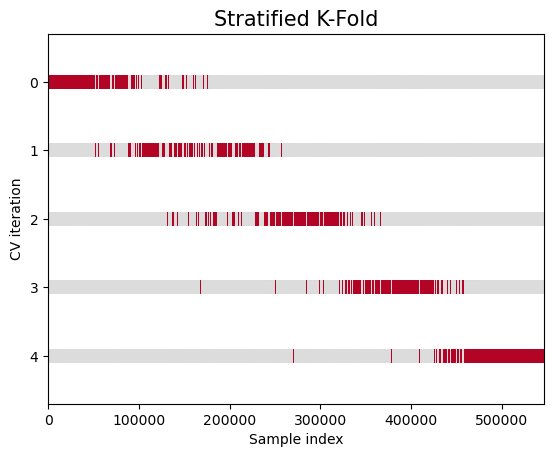

In [35]:
# Stratified Kfold를 시각화합니다.
# 앞의 kfold에서 정의한 시각화 함수를 사용합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=cut_Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Stratified K-Fold')

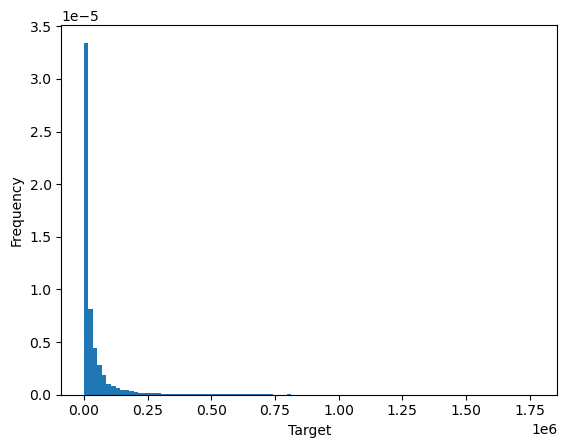

In [37]:
# 원래 Target값의 분포를 확인합니다.
plt.hist(Y_train, bins=100, density=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

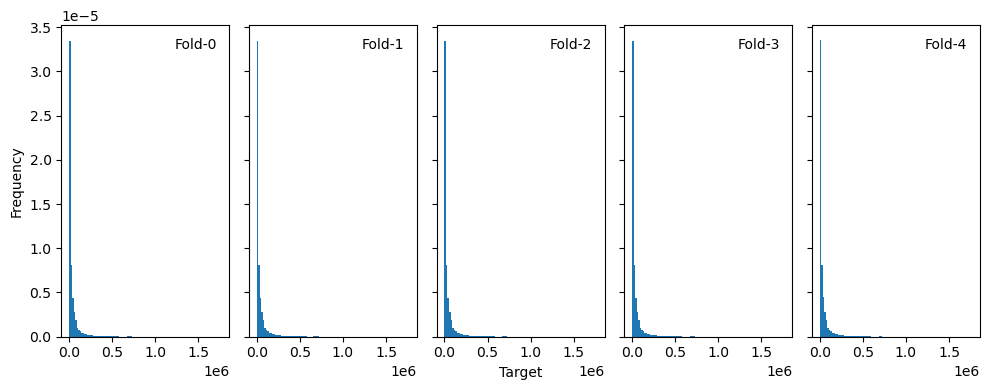

In [38]:
# 각 Fold별 분포를 시각화합니다.
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10,4)) # 5개의 plot을 만듭니다.
for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(X_train, cut_Y_train)): # fold별로 iteration을 만듭니다.
    axs[fold_idx].hist(Y_train[train_idx], bins=100, density=True, label=f'Fold-{fold_idx}') # 각 fold에 해당하는 Target값을 가져옵니다.
    if fold_idx == 0:
        axs[fold_idx].set_ylabel('Frequency')
    if fold_idx == 2:
        axs[fold_idx].set_xlabel("Target")
    axs[fold_idx].legend(frameon=False, handlelength=0)
plt.tight_layout()
plt.show()

- 동일한 분포의 Target값을 가지는 것을 확인할 수 있습니다.

In [39]:
# 학습 데이터를 Stratified Kfold로 나눕니다.
train_folds = kf.split(X_train, cut_Y_train)
display(train_folds)

<generator object _BaseKFold.split at 0x173365360>

In [42]:
# 학습을 진행합니다.

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold, # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse', # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10), # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)] # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"Stratified_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


--------0번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8135
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 41839.015310
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34712	training's l2: 1.20492e+09	valid_1's rmse: 33454.2	valid_1's l2: 1.11918e+09
[20]	training's rmse: 12739.4	training's l2: 1.62292e+08	valid_1's rmse: 13021	valid_1's l2: 1.69547e+08
[30]	training's rmse: 5652.06	training's l2: 3.19458e+07	valid_1's rmse: 8782.53	valid_1's l2: 7.71329e+07
[40]	training's rmse: 3798.97	training's l2: 1.44322e+07	valid_1's rmse: 8105.08	valid_1's l2: 6.56924e+07
[50]	training's rmse: 3347.59	training's l2: 1.12064e+07	valid_1

'--------0번째 fold는 Stratified_kfold0_gbm.pkl에 저장되었습니다.--------\n\n'

--------1번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8140
[LightGBM] [Info] Number of data points in the train set: 437161, number of used features: 42
[LightGBM] [Info] Start training from score 41826.840073
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34695.8	training's l2: 1.2038e+09	valid_1's rmse: 34905.2	valid_1's l2: 1.21837e+09
[20]	training's rmse: 12770.8	training's l2: 1.63094e+08	valid_1's rmse: 12872	valid_1's l2: 1.65689e+08
[30]	training's rmse: 5707.72	training's l2: 3.25781e+07	valid_1's rmse: 5823.99	valid_1's l2: 3.39188e+07
[40]	training's rmse: 3873.98	training's l2: 1.50077e+07	valid_1's rmse: 4069.13	valid_1's l2: 1.65578e+07
[50]	training's rmse: 3417.34	training's l2: 1.16782e+07	valid_

'--------1번째 fold는 Stratified_kfold1_gbm.pkl에 저장되었습니다.--------\n\n'

--------2번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8130
[LightGBM] [Info] Number of data points in the train set: 437162, number of used features: 42
[LightGBM] [Info] Start training from score 41836.794012
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34718.9	training's l2: 1.2054e+09	valid_1's rmse: 34781.2	valid_1's l2: 1.20973e+09
[20]	training's rmse: 12761.7	training's l2: 1.62861e+08	valid_1's rmse: 12828.8	valid_1's l2: 1.64578e+08
[30]	training's rmse: 5706.06	training's l2: 3.25591e+07	valid_1's rmse: 5738.05	valid_1's l2: 3.29252e+07
[40]	training's rmse: 3879.14	training's l2: 1.50477e+07	valid_1's rmse: 3905.38	valid_1's l2: 1.5252e+07
[50]	training's rmse: 3428.65	training's l2: 1.17556e+07	valid

'--------2번째 fold는 Stratified_kfold2_gbm.pkl에 저장되었습니다.--------\n\n'

--------3번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 437162, number of used features: 42
[LightGBM] [Info] Start training from score 41866.525396
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34756.5	training's l2: 1.20802e+09	valid_1's rmse: 34257.8	valid_1's l2: 1.1736e+09
[20]	training's rmse: 12741.3	training's l2: 1.6234e+08	valid_1's rmse: 12324.3	valid_1's l2: 1.51888e+08
[30]	training's rmse: 5642.52	training's l2: 3.18381e+07	valid_1's rmse: 5388.26	valid_1's l2: 2.90334e+07
[40]	training's rmse: 3797.99	training's l2: 1.44247e+07	valid_1's rmse: 3741.7	valid_1's l2: 1.40003e+07
[50]	training's rmse: 3376.71	training's l2: 1.14022e+07	valid_

'--------3번째 fold는 Stratified_kfold3_gbm.pkl에 저장되었습니다.--------\n\n'

--------4번째 fold의 학습을 시작합니다.--------
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8028
[LightGBM] [Info] Number of data points in the train set: 437162, number of used features: 42
[LightGBM] [Info] Start training from score 41841.813497
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34708.5	training's l2: 1.20468e+09	valid_1's rmse: 34952.2	valid_1's l2: 1.22165e+09
[20]	training's rmse: 12711.3	training's l2: 1.61577e+08	valid_1's rmse: 13128	valid_1's l2: 1.72344e+08
[30]	training's rmse: 5582.03	training's l2: 3.11591e+07	valid_1's rmse: 6189.69	valid_1's l2: 3.83123e+07
[40]	training's rmse: 3692.51	training's l2: 1.36346e+07	valid_1's rmse: 4435.64	valid_1's l2: 1.96749e+07
[50]	training's rmse: 3236.77	training's l2: 1.04767e+07	valid

'--------4번째 fold는 Stratified_kfold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [43]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'Stratified_kfold0_gbm.pkl - Test rmse : 3860.542317399142'

'Stratified_kfold1_gbm.pkl - Test rmse : 3600.3209392557237'

'Stratified_kfold2_gbm.pkl - Test rmse : 3500.8021112229094'

'Stratified_kfold3_gbm.pkl - Test rmse : 3436.7329546289543'

'Stratified_kfold4_gbm.pkl - Test rmse : 3483.8671152799225'

'최종 Test rmse : 3378.2797752728734'

In [45]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
# 실습하는 과정에서 가장 잘 나온 3개로 한번 테스트를 진행해보시기 바랍니다.
top_3_files = ["Stratified_kfold1_gbm.pkl", "Stratified_kfold2_gbm.pkl", "Stratified_kfold3_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'Stratified_kfold1_gbm.pkl - Test rmse : 3600.3209392557237'

'Stratified_kfold2_gbm.pkl - Test rmse : 3500.8021112229094'

'Stratified_kfold3_gbm.pkl - Test rmse : 3436.7329546289543'

'최종 Test rmse : 3339.924480651084'

- StratifiedKfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 1분 41초
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 3292.13
  - Test RMSE(Top3) : 3357.02
  - Test RMSE(Top1) : 3237.07

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07

#### 📚 자료

- [KFold - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

### 2-4. Group K-Fold


#### 📝 설명 : (2-4)
- 특정 목적하에 사용되는 확장된 K-Fold 방법입니다.
- Train과 Valid에 같은 값이 들어가지 않도록 Group을 구성 후, Fold별로 Group을 분배합니다.
- 이번 실습에서는 group을 종목별과 산업군별로 각각 group kfold를 적용해봅니다.


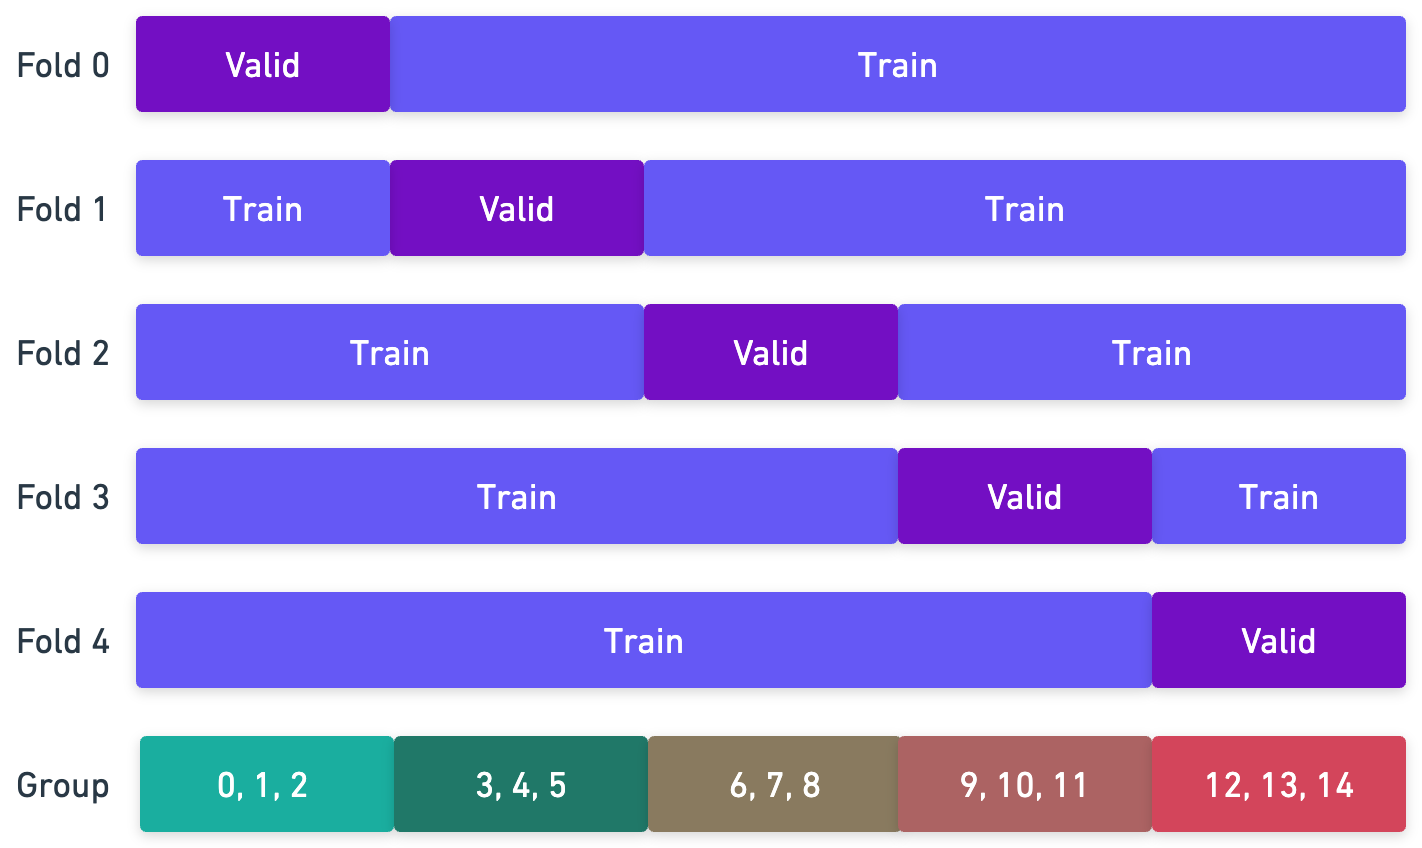

#### 👨‍💻 코드 : (2-4)


In [46]:
# 종목(code)를 Group을 나누는 기준으로 사용합니다.
groups = list(X_train['LEncodedCode'].astype('int'))

In [47]:
# GroupKfold 함수를 선언합니다.
kf = GroupKFold(n_splits=5)

Fold 0 :
  Train : index=[1 2 3 5 6]...
  Valid : index=[ 0  4  8 11 15]...
Fold 1 :
  Train : index=[0 1 2 4 5]...
  Valid : index=[ 3  7 10 14 18]...
Fold 2 :
  Train : index=[0 1 3 4 5]...
  Valid : index=[ 2  6  9 13 17]...
Fold 3 :
  Train : index=[0 2 3 4 6]...
  Valid : index=[ 1  5 12 16 20]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[2851 2860 2861 2868 2881]...


<Axes: title={'center': 'Code Group K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

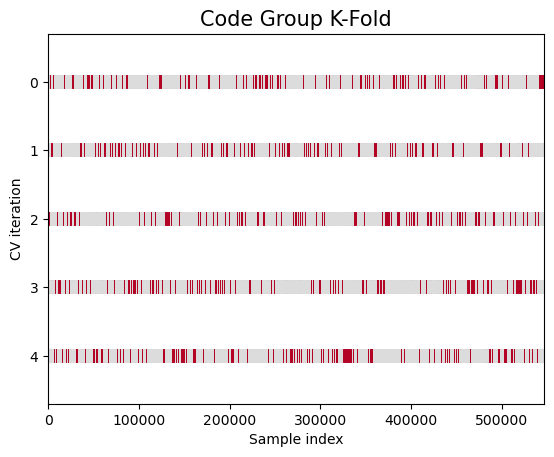

In [48]:
# GroupKfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train.sort_values(by='LEncodedCode'),
                y=Y_train,
                cv=kf,
                group=groups,
                ax=ax,
                split_strategy='Code Group K-Fold')

In [49]:
# 학습 데이터를 GroupKfold로 나눕니다.
train_folds = kf.split(X_train, Y_train, groups=groups)
display(train_folds)

<generator object _BaseKFold.split at 0x173364040>

- Kfold적용 시, 결과는 generator object로 반환됩니다.
- python generator는 iterator를 생성해주는 함수이다.
- 즉, loop를 통해 불러올때 값을 확인할 수 있습니다.

In [51]:
# 학습을 진행합니다.

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"groupd_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8124
[LightGBM] [Info] Number of data points in the train set: 437169, number of used features: 42
[LightGBM] [Info] Start training from score 39263.613760
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 33393.1	training's l2: 1.1151e+09	valid_1's rmse: 43799.1	valid_1's l2: 1.91836e+09
[20]	training's rmse: 12237.3	training's l2: 1.49751e+08	valid_1's rmse: 21146.1	valid_1's l2: 4.47157e+08
[30]	training's rmse: 5412.87	training's l2: 2.92992e+07	valid_1's rmse: 14518.3	valid_1's l2: 2.10781e+08
[40]	training's rmse: 3627.24	training's l2: 1.31569e+07	valid_1's rmse: 12286.3	valid_1's l2: 1.50953e+08
[50]	training's rmse: 3198.79	training's l2: 1.02322e+07	valid_1's rmse: 11845.5	valid_1's l2: 1.4

'--------0번째 fold는 groupd_kfold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8128
[LightGBM] [Info] Number of data points in the train set: 437163, number of used features: 42
[LightGBM] [Info] Start training from score 43779.460885
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36623.3	training's l2: 1.34126e+09	valid_1's rmse: 24060	valid_1's l2: 5.78881e+08
[20]	training's rmse: 13352.2	training's l2: 1.78281e+08	valid_1's rmse: 21869	valid_1's l2: 4.78253e+08
Early stopping, best iteration is:
[15]	training's rmse: 21926.5	training's l2: 4.80773e+08	valid_1's rmse: 20538.3	valid_1's l2: 4.21821e+08


'--------1번째 fold는 groupd_kfold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8132
[LightGBM] [Info] Number of data points in the train set: 437176, number of used features: 42
[LightGBM] [Info] Start training from score 42142.927507
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 34876.5	training's l2: 1.21637e+09	valid_1's rmse: 34248	valid_1's l2: 1.17293e+09
[20]	training's rmse: 12777.6	training's l2: 1.63267e+08	valid_1's rmse: 13193.7	valid_1's l2: 1.74073e+08
[30]	training's rmse: 5618.62	training's l2: 3.15689e+07	valid_1's rmse: 7054.69	valid_1's l2: 4.97686e+07
[40]	training's rmse: 3732.32	training's l2: 1.39302e+07	valid_1's rmse: 5772.02	valid_1's l2: 3.33163e+07
[50]	training's rmse: 3293.57	training's l2: 1.08476e+07	valid_1's rmse: 5546.65	valid_1's l2: 3.07

'--------2번째 fold는 groupd_kfold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8117
[LightGBM] [Info] Number of data points in the train set: 437142, number of used features: 42
[LightGBM] [Info] Start training from score 42062.048986
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 33014.5	training's l2: 1.08996e+09	valid_1's rmse: 60343.8	valid_1's l2: 3.64137e+09
[20]	training's rmse: 12088.4	training's l2: 1.46129e+08	valid_1's rmse: 44053.7	valid_1's l2: 1.94072e+09
[30]	training's rmse: 5359.9	training's l2: 2.87285e+07	valid_1's rmse: 38677.3	valid_1's l2: 1.49594e+09
[40]	training's rmse: 3606.12	training's l2: 1.30041e+07	valid_1's rmse: 37326.1	valid_1's l2: 1.39324e+09
[50]	training's rmse: 3198.51	training's l2: 1.02305e+07	valid_1's rmse: 36870.4	valid_1's l2: 1.3

'--------3번째 fold는 groupd_kfold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8122
[LightGBM] [Info] Number of data points in the train set: 437158, number of used features: 42
[LightGBM] [Info] Start training from score 41962.975581
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35414.1	training's l2: 1.25416e+09	valid_1's rmse: 30906.7	valid_1's l2: 9.55225e+08
[20]	training's rmse: 12975.3	training's l2: 1.68357e+08	valid_1's rmse: 11164.9	valid_1's l2: 1.24655e+08
[30]	training's rmse: 5714.97	training's l2: 3.26608e+07	valid_1's rmse: 5929.29	valid_1's l2: 3.51565e+07
[40]	training's rmse: 3805.28	training's l2: 1.44802e+07	valid_1's rmse: 5173.66	valid_1's l2: 2.67668e+07
[50]	training's rmse: 3349.3	training's l2: 1.12178e+07	valid_1's rmse: 5179.36	valid_1's l2: 2.6

'--------4번째 fold는 groupd_kfold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [52]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'groupd_kfold0_gbm.pkl - Test rmse : 3777.0912527371615'

'groupd_kfold1_gbm.pkl - Test rmse : 17322.666178243846'

'groupd_kfold2_gbm.pkl - Test rmse : 3774.343636072981'

'groupd_kfold3_gbm.pkl - Test rmse : 3344.4582904072345'

'groupd_kfold4_gbm.pkl - Test rmse : 3924.876774977956'

'최종 Test rmse : 4949.843075140986'

In [53]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["groupd_kfold0_gbm.pkl", "groupd_kfold2_gbm.pkl", "groupd_kfold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'groupd_kfold0_gbm.pkl - Test rmse : 3777.0912527371615'

'groupd_kfold2_gbm.pkl - Test rmse : 3774.343636072981'

'groupd_kfold4_gbm.pkl - Test rmse : 3924.876774977956'

'최종 Test rmse : 3351.8427399891707'

- 종목별 Group Kfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 50s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 4912.87
  - Test RMSE(Top3) : 3442.06
  - Test RMSE(Top1) : 3637.26

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06

- 위 예시는 종목별 구분이지만, IT와 같이 산업군으로 group을 나누어 적용해 볼 수 있습니다.

#### 👨‍💻 코드 : (2-4)

In [54]:
# 산업군(Industry)를 Group을 나누는 기준으로 사용합니다.
groups = list(X_train['LEncodedIndustry'].astype('int'))

In [55]:
# GroupKfold 함수를 선언합니다.
kf = GroupKFold(n_splits=5)

Fold 0 :
  Train : index=[2840 2841 2842 2843 2844]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[27489 27490 27491 27492 27493]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[103947 103948 103949 103950 103951]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[78578 78579 78580 78581 78582]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[2840 2841 2842 2843 2844]...


<Axes: title={'center': 'Industry Group K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

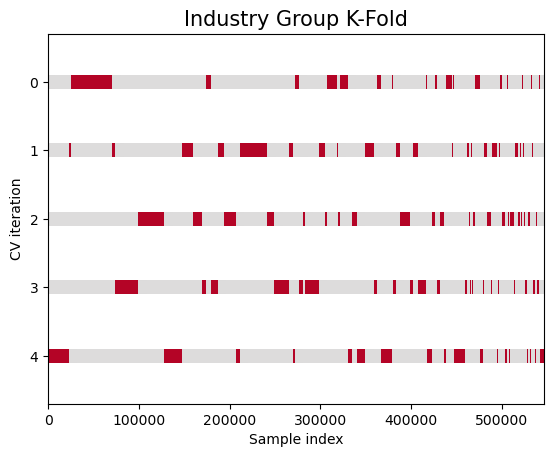

In [56]:
# GroupKfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train.sort_values(by='LEncodedIndustry'),
                y=Y_train,
                cv=kf,
                group=groups,
                ax=ax,
                split_strategy='Industry Group K-Fold')

In [57]:
# 학습 데이터를 GroupKfold로 나눕니다.
train_folds = kf.split(X_train, Y_train, groups=groups)
display(train_folds)

<generator object _BaseKFold.split at 0x1733660e0>

- Kfold적용 시, 결과는 generator object로 반환됩니다.
- python generator는 iterator를 생성해주는 함수이다.
- 즉, loop를 통해 불러올때 값을 확인할 수 있습니다.

In [59]:
# 학습을 진행합니다.

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"industry_groupd_kfold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8084
[LightGBM] [Info] Number of data points in the train set: 437099, number of used features: 42
[LightGBM] [Info] Start training from score 44935.493529
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 37949.3	training's l2: 1.44015e+09	valid_1's rmse: 16004.7	valid_1's l2: 2.5615e+08
[20]	training's rmse: 13855.2	training's l2: 1.91967e+08	valid_1's rmse: 5759.25	valid_1's l2: 3.3169e+07
[30]	training's rmse: 6049.96	training's l2: 3.6602e+07	valid_1's rmse: 2442.23	valid_1's l2: 5.96447e+06
[40]	training's rmse: 4000.7	training's l2: 1.60056e+07	valid_1's rmse: 1601.98	valid_1's l2: 2.56635e+06
[50]	training's rmse: 3528.66	training's l2: 1.24514e+07	valid_1's rmse: 1462.44	valid_1's l2: 2.1387

'--------0번째 fold는 industry_groupd_kfold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8079
[LightGBM] [Info] Number of data points in the train set: 437121, number of used features: 42
[LightGBM] [Info] Start training from score 44907.760821
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36010.3	training's l2: 1.29674e+09	valid_1's rmse: 28190	valid_1's l2: 7.94678e+08
[20]	training's rmse: 13158.8	training's l2: 1.73153e+08	valid_1's rmse: 9657.71	valid_1's l2: 9.32713e+07
[30]	training's rmse: 5763.65	training's l2: 3.32197e+07	valid_1's rmse: 4842.58	valid_1's l2: 2.34506e+07
[40]	training's rmse: 3833.24	training's l2: 1.46937e+07	valid_1's rmse: 4383.96	valid_1's l2: 1.92191e+07
Early stopping, best iteration is:
[37]	training's rmse: 4152.37	training's l2: 1.72421e+07	valid_1

'--------1번째 fold는 industry_groupd_kfold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8081
[LightGBM] [Info] Number of data points in the train set: 437010, number of used features: 42
[LightGBM] [Info] Start training from score 42223.873124
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35776.9	training's l2: 1.27999e+09	valid_1's rmse: 29398.7	valid_1's l2: 8.64286e+08
[20]	training's rmse: 13068.4	training's l2: 1.70784e+08	valid_1's rmse: 12935.1	valid_1's l2: 1.67316e+08
[30]	training's rmse: 5705.67	training's l2: 3.25547e+07	valid_1's rmse: 10291.1	valid_1's l2: 1.05906e+08
[40]	training's rmse: 3765.43	training's l2: 1.41785e+07	valid_1's rmse: 10206	valid_1's l2: 1.04163e+08
Early stopping, best iteration is:
[35]	training's rmse: 4393.32	training's l2: 1.93013e+07	valid_1

'--------2번째 fold는 industry_groupd_kfold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8077
[LightGBM] [Info] Number of data points in the train set: 436997, number of used features: 42
[LightGBM] [Info] Start training from score 41551.856155
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 33542.4	training's l2: 1.12509e+09	valid_1's rmse: 44084.3	valid_1's l2: 1.94342e+09
[20]	training's rmse: 12269.6	training's l2: 1.50542e+08	valid_1's rmse: 22137.3	valid_1's l2: 4.9006e+08
[30]	training's rmse: 5380.98	training's l2: 2.8955e+07	valid_1's rmse: 16036.1	valid_1's l2: 2.57155e+08
[40]	training's rmse: 3550.57	training's l2: 1.26065e+07	valid_1's rmse: 14191.5	valid_1's l2: 2.01398e+08
[50]	training's rmse: 3115.57	training's l2: 9.70679e+06	valid_1's rmse: 13579.3	valid_1's l2: 1.84

'--------3번째 fold는 industry_groupd_kfold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8080
[LightGBM] [Info] Number of data points in the train set: 437581, number of used features: 42
[LightGBM] [Info] Start training from score 35598.745179
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 29507	training's l2: 8.70662e+08	valid_1's rmse: 69591.6	valid_1's l2: 4.84299e+09
[20]	training's rmse: 10905.5	training's l2: 1.18931e+08	valid_1's rmse: 47835.2	valid_1's l2: 2.2882e+09
[30]	training's rmse: 4953.89	training's l2: 2.4541e+07	valid_1's rmse: 42148.5	valid_1's l2: 1.77649e+09
[40]	training's rmse: 3408.72	training's l2: 1.16194e+07	valid_1's rmse: 40431.1	valid_1's l2: 1.63467e+09
[50]	training's rmse: 3017.81	training's l2: 9.10718e+06	valid_1's rmse: 39819.1	valid_1's l2: 1.5855

'--------4번째 fold는 industry_groupd_kfold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [60]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'industry_groupd_kfold0_gbm.pkl - Test rmse : 3316.0408545452547'

'industry_groupd_kfold1_gbm.pkl - Test rmse : 3982.473364799556'

'industry_groupd_kfold2_gbm.pkl - Test rmse : 4201.362723333444'

'industry_groupd_kfold3_gbm.pkl - Test rmse : 3889.25395270525'

'industry_groupd_kfold4_gbm.pkl - Test rmse : 5946.272401575868'

'최종 Test rmse : 3512.3965118983656'

In [61]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["industry_groupd_kfold0_gbm.pkl", "industry_groupd_kfold1_gbm.pkl", "industry_groupd_kfold2_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'industry_groupd_kfold0_gbm.pkl - Test rmse : 3316.0408545452547'

'industry_groupd_kfold1_gbm.pkl - Test rmse : 3982.473364799556'

'industry_groupd_kfold2_gbm.pkl - Test rmse : 4201.362723333444'

'최종 Test rmse : 3411.9198210799836'

- 산업군별 Group Kfold 학습의 최종결과는 아래와 같습니다.
  - Training Time : 29.9s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 3529.99
  - Test RMSE(Top3) : 3288.77
  - Test RMSE(Top1) : 3347.86

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06
  - 산업군별 Group KFold(Top3) : 3288.77

#### 📚 자료

- [GroupKFold - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)

### 2-5. Time-Series Split


#### 📝 설명 : (2-5)

- 시계열 데이터에 사용되는 확장된 K-Fold 방법입니다.
- 과거의 데이터를 통해 미래를 예측하는 데이터의 구조를 유지한 채 Fold를 나누는 방법입니다.

<br>
<img src="https://velog.velcdn.com/images/dlehd1989/post/eedadef4-631b-4684-ad65-899db85192d9/image.png">
<br>


#### 👨‍💻 코드 : (2-5)


In [62]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[91077 91078 91079 91080 91081]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[182152 182153 182154 182155 182156]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[273227 273228 273229 273230 273231]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[364302 364303 364304 364305 364306]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[455377 455378 455379 455380 455381]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

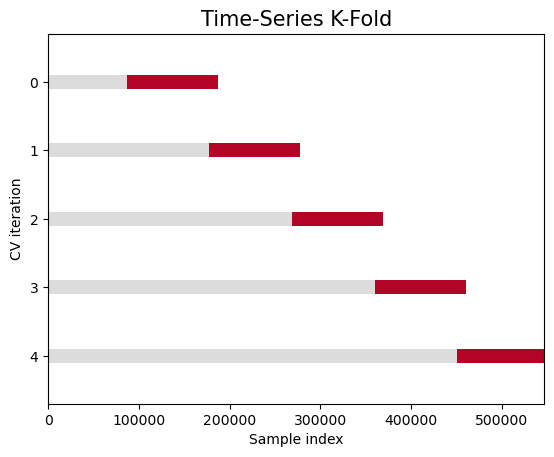

In [63]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [64]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object TimeSeriesSplit.split at 0x286c13120>

In [65]:
# 학습을 진행합니다.

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7612
[LightGBM] [Info] Number of data points in the train set: 91077, number of used features: 42
[LightGBM] [Info] Start training from score 57027.638548
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 46891.9	training's l2: 2.19885e+09	valid_1's rmse: 46829	valid_1's l2: 2.19296e+09
[20]	training's rmse: 16756.1	training's l2: 2.80768e+08	valid_1's rmse: 19959.4	valid_1's l2: 3.98378e+08
[30]	training's rmse: 6663.44	training's l2: 4.44014e+07	valid_1's rmse: 12416	valid_1's l2: 1.54158e+08
[40]	training's rmse: 3756.12	training's l2: 1.41084e+07	valid_1's rmse: 10693.1	valid_1's l2: 1.14343e+08
[50]	training's rmse: 3066.54	training's l2: 9.40364e+06	valid_1's rmse: 10198.5	valid_1's l2: 1.0401e

'--------0번째 fold는 timeseries_fold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7840
[LightGBM] [Info] Number of data points in the train set: 182152, number of used features: 42
[LightGBM] [Info] Start training from score 60054.760321
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 45683.7	training's l2: 2.087e+09	valid_1's rmse: 29686.5	valid_1's l2: 8.81285e+08
[20]	training's rmse: 16550.5	training's l2: 2.73919e+08	valid_1's rmse: 10710.5	valid_1's l2: 1.14715e+08
[30]	training's rmse: 7034.78	training's l2: 4.94881e+07	valid_1's rmse: 4669.8	valid_1's l2: 2.1807e+07
[40]	training's rmse: 4475.55	training's l2: 2.00306e+07	valid_1's rmse: 3261.42	valid_1's l2: 1.06368e+07
[50]	training's rmse: 3903.28	training's l2: 1.52356e+07	valid_1's rmse: 2938.68	valid_1's l2: 8.6358

'--------1번째 fold는 timeseries_fold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7888
[LightGBM] [Info] Number of data points in the train set: 273227, number of used features: 42
[LightGBM] [Info] Start training from score 49230.100049
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 40925.8	training's l2: 1.67492e+09	valid_1's rmse: 16958.6	valid_1's l2: 2.87593e+08
[20]	training's rmse: 14875.2	training's l2: 2.2127e+08	valid_1's rmse: 6067.48	valid_1's l2: 3.68143e+07
[30]	training's rmse: 6382.46	training's l2: 4.07357e+07	valid_1's rmse: 2442.71	valid_1's l2: 5.96685e+06
[40]	training's rmse: 4118.51	training's l2: 1.69622e+07	valid_1's rmse: 1453.49	valid_1's l2: 2.11264e+06
[50]	training's rmse: 3588.59	training's l2: 1.2878e+07	valid_1's rmse: 1270.1	valid_1's l2: 1.613

'--------2번째 fold는 timeseries_fold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7942
[LightGBM] [Info] Number of data points in the train set: 364302, number of used features: 42
[LightGBM] [Info] Start training from score 42853.119055
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36424.5	training's l2: 1.32674e+09	valid_1's rmse: 33139	valid_1's l2: 1.0982e+09
[20]	training's rmse: 13321	training's l2: 1.7745e+08	valid_1's rmse: 12585.1	valid_1's l2: 1.58385e+08
[30]	training's rmse: 5832.67	training's l2: 3.40201e+07	valid_1's rmse: 6143.03	valid_1's l2: 3.77368e+07
[40]	training's rmse: 3848.92	training's l2: 1.48142e+07	valid_1's rmse: 4495.89	valid_1's l2: 2.0213e+07
[50]	training's rmse: 3374.2	training's l2: 1.13852e+07	valid_1's rmse: 4300.2	valid_1's l2: 1.84917e+07

'--------3번째 fold는 timeseries_fold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7996
[LightGBM] [Info] Number of data points in the train set: 455377, number of used features: 42
[LightGBM] [Info] Start training from score 42374.640265
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35774.5	training's l2: 1.27981e+09	valid_1's rmse: 28436.7	valid_1's l2: 8.08645e+08
[20]	training's rmse: 13072.2	training's l2: 1.70884e+08	valid_1's rmse: 10365.1	valid_1's l2: 1.07435e+08
[30]	training's rmse: 5716.61	training's l2: 3.26796e+07	valid_1's rmse: 4928.8	valid_1's l2: 2.42931e+07
[40]	training's rmse: 3778.9	training's l2: 1.42801e+07	valid_1's rmse: 3805.41	valid_1's l2: 1.44812e+07
[50]	training's rmse: 3328.76	training's l2: 1.10806e+07	valid_1's rmse: 3648.19	valid_1's l2: 1.33

'--------4번째 fold는 timeseries_fold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [66]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 7533.697929290577'

'timeseries_fold1_gbm.pkl - Test rmse : 3513.3011589699204'

'timeseries_fold2_gbm.pkl - Test rmse : 3640.7054445984413'

'timeseries_fold3_gbm.pkl - Test rmse : 4140.965932922118'

'timeseries_fold4_gbm.pkl - Test rmse : 3656.298917638036'

'최종 Test rmse : 3636.231624841337'

In [67]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold0_gbm.pkl", "timeseries_fold2_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 7533.697929290577'

'timeseries_fold2_gbm.pkl - Test rmse : 3640.7054445984413'

'timeseries_fold4_gbm.pkl - Test rmse : 3656.298917638036'

'최종 Test rmse : 4117.057315872517'

- Time-Series Split 학습의 최종결과는 아래와 같습니다.
  - Training Time : 33.2 s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 3295.32
  - Test RMSE(Top3) : 3211.75
  - Test RMSE(Top1) : 3385.43

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06
  - 산업군별 Group KFold(Top3) : 3288.77
  - TimeSeries KFold(Top3) : 3211.75

❗ **최종적으로 아래와 같은 결과를 얻을 수 있습니다.**


| Method                 | Training Time | Test RMSE (ALL) | Test RMSE (Top3) | Test RMSE (Top1) |
|------------------------|---------------|-----------------|------------------|------------------|
| Holdout                | 29.9s         | 3487.40         | -                | -                |
| K-Fold                 | 40.5s         | 5290.11         | 3243.60          | 3447.76          |
| StratifiedKfold        | 101s      | 3292.13         | 3357.02          | 3237.07          |
| 종목별 Group Kfold      | 50s           | 4912.87         | 3442.06          | 3637.26          |
| 산업군별 Group Kfold     | 44.7s         | 3529.99         | 3288.77          | 3347.86          |
| Time-Series Split      | 33.2s         | 3295.32         | 3211.75          | 3385.43          |


- 주가데이터의 형태와 비슷한 Time-Series Split이 가장 좋은 성능을 보였습니다.
- 따라서, 주어진 데이터를 분석하고 도메인에 맞는 분할을 적용하는 것이 중요합니다.

#### 📚 자료

- [TimeSeriesSplit - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

### Appendix. Time-Series Split (Split by Time index)


#### 📝 설명 : Appendix

- 위 시계열 분할 과정에 대해, 데이터를 "TimeSeries 정렬"로 분할하여 학습을 진행하는 과정입니다.

<br>
<img src="https://velog.velcdn.com/images/dlehd1989/post/eedadef4-631b-4684-ad65-899db85192d9/image.png">
<br>


#### 👨‍💻 코드 : Appendix


In [68]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

In [69]:
# 시간순 정렬을 위해 이전에 저장해두었던 시간정보를 붙입니다.
X_train['Date'] = date_list

X_train = X_train.sort_values(by='Date') # 시간순으로 정렬합니다.
Y_train = Y_train.reindex(X_train.index) # 정렬된 X_train의 인덱스에 맞추어 Y_train도 정렬해줍니다.

X_train = X_train.reset_index(drop=True) # 인덱스를 재정렬 해줍니다.
Y_train = Y_train.reset_index(drop=True)

del X_train['Date'] # 시간에 대한 정보를 지웁니다.

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[91077 91078 91079 91080 91081]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[182152 182153 182154 182155 182156]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[273227 273228 273229 273230 273231]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[364302 364303 364304 364305 364306]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[455377 455378 455379 455380 455381]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

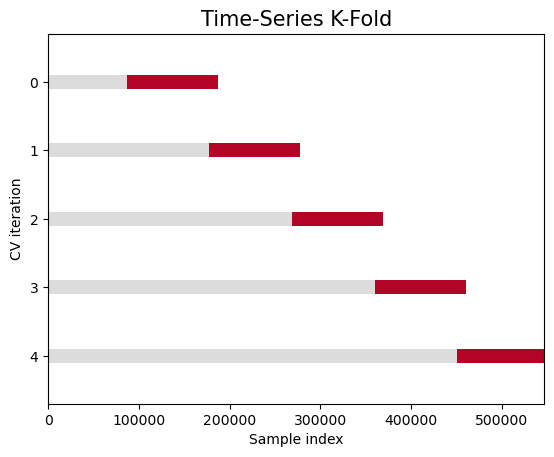

In [70]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [71]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object TimeSeriesSplit.split at 0x286c11d00>

In [72]:
# 학습을 진행합니다.

fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)


'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8119
[LightGBM] [Info] Number of data points in the train set: 91077, number of used features: 41
[LightGBM] [Info] Start training from score 36928.834514
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 33560.2	training's l2: 1.12629e+09	valid_1's rmse: 43470.5	valid_1's l2: 1.88969e+09
[20]	training's rmse: 12044.5	training's l2: 1.45071e+08	valid_1's rmse: 19788.6	valid_1's l2: 3.9159e+08
[30]	training's rmse: 4899.54	training's l2: 2.40055e+07	valid_1's rmse: 13024.8	valid_1's l2: 1.69645e+08
[40]	training's rmse: 2894.97	training's l2: 8.38083e+06	valid_1's rmse: 11431.3	valid_1's l2: 1.30675e+08
[50]	training's rmse: 2419.94	training's l2: 5.8561e+06	valid_1's rmse: 11000.5	valid_1's l2: 1.210

'--------0번째 fold는 timeseries_fold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8134
[LightGBM] [Info] Number of data points in the train set: 182152, number of used features: 42
[LightGBM] [Info] Start training from score 41859.213113
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 37138.5	training's l2: 1.37927e+09	valid_1's rmse: 35552	valid_1's l2: 1.26394e+09
[20]	training's rmse: 13464.7	training's l2: 1.81298e+08	valid_1's rmse: 12500.3	valid_1's l2: 1.56258e+08
[30]	training's rmse: 5699.86	training's l2: 3.24884e+07	valid_1's rmse: 9824.41	valid_1's l2: 9.6519e+07
Early stopping, best iteration is:
[28]	training's rmse: 6603.38	training's l2: 4.36046e+07	valid_1's rmse: 9698.8	valid_1's l2: 9.40668e+07


'--------1번째 fold는 timeseries_fold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8137
[LightGBM] [Info] Number of data points in the train set: 273227, number of used features: 42
[LightGBM] [Info] Start training from score 43752.054797
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 37879	training's l2: 1.43482e+09	valid_1's rmse: 31169.6	valid_1's l2: 9.71544e+08
[20]	training's rmse: 13792.2	training's l2: 1.90226e+08	valid_1's rmse: 12912.1	valid_1's l2: 1.66723e+08
[30]	training's rmse: 5950.1	training's l2: 3.54037e+07	valid_1's rmse: 9952.94	valid_1's l2: 9.90609e+07
[40]	training's rmse: 3865.82	training's l2: 1.49446e+07	valid_1's rmse: 10102	valid_1's l2: 1.0205e+08
Early stopping, best iteration is:
[32]	training's rmse: 5260.76	training's l2: 2.76756e+07	valid_1's r

'--------2번째 fold는 timeseries_fold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8137
[LightGBM] [Info] Number of data points in the train set: 364302, number of used features: 42
[LightGBM] [Info] Start training from score 43294.109972
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 36560.7	training's l2: 1.33668e+09	valid_1's rmse: 30377.9	valid_1's l2: 9.22817e+08
[20]	training's rmse: 13367	training's l2: 1.78675e+08	valid_1's rmse: 11269.5	valid_1's l2: 1.27001e+08
[30]	training's rmse: 5853.07	training's l2: 3.42584e+07	valid_1's rmse: 5251.98	valid_1's l2: 2.75833e+07
[40]	training's rmse: 3876.27	training's l2: 1.50254e+07	valid_1's rmse: 3882.32	valid_1's l2: 1.50724e+07
[50]	training's rmse: 3397.22	training's l2: 1.15411e+07	valid_1's rmse: 3651.48	valid_1's l2: 1.33

'--------3번째 fold는 timeseries_fold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8139
[LightGBM] [Info] Number of data points in the train set: 455377, number of used features: 42
[LightGBM] [Info] Start training from score 42313.000169
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35427.7	training's l2: 1.25512e+09	valid_1's rmse: 30780	valid_1's l2: 9.47407e+08
[20]	training's rmse: 12974.4	training's l2: 1.68335e+08	valid_1's rmse: 11408.2	valid_1's l2: 1.30148e+08
[30]	training's rmse: 5721.45	training's l2: 3.2735e+07	valid_1's rmse: 5326.92	valid_1's l2: 2.83761e+07
[40]	training's rmse: 3840.61	training's l2: 1.47503e+07	valid_1's rmse: 3907.13	valid_1's l2: 1.52657e+07
[50]	training's rmse: 3405.92	training's l2: 1.16003e+07	valid_1's rmse: 3625.68	valid_1's l2: 1.314

'--------4번째 fold는 timeseries_fold4_gbm.pkl에 저장되었습니다.--------\n\n'

In [73]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(fold_save_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold0_gbm.pkl - Test rmse : 32535.057330263837'

'timeseries_fold1_gbm.pkl - Test rmse : 8312.447774355289'

'timeseries_fold2_gbm.pkl - Test rmse : 4792.321715339006'

'timeseries_fold3_gbm.pkl - Test rmse : 3682.0384317728863'

'timeseries_fold4_gbm.pkl - Test rmse : 3587.9300777756707'

'최종 Test rmse : 8445.220911697392'

In [74]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold2_gbm.pkl", "timeseries_fold3_gbm.pkl", "timeseries_fold4_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    # 각 fold의 rmse를 측정합니다.
    RMSE = mean_squared_error(Y_test, fold_predicts)**0.5
    display(f"{file_name} - Test rmse : {RMSE}")

    total_predicts += fold_predicts / len(top_3_files)

RMSE = mean_squared_error(Y_test, total_predicts)**0.5
display(f"최종 Test rmse : {RMSE}")

'timeseries_fold2_gbm.pkl - Test rmse : 4792.321715339006'

'timeseries_fold3_gbm.pkl - Test rmse : 3682.0384317728863'

'timeseries_fold4_gbm.pkl - Test rmse : 3587.9300777756707'

'최종 Test rmse : 3607.4574120697384'

# - 시간순으로 정렬된 Time-Series Split 학습의 최종결과는 아래와 같습니다.
  - Training Time : 33.2 s
  - Train RMSE : fold마다 다름
  - Valid RMSE : fold마다 다름
  - Test RMSE(ALL) : 8570.08
  - Test RMSE(Top3) : 3578.11
  - Test RMSE(Top1) : 3442.75

- 현재까지 분할 별 Test RMSE 결과는 아래와 같습니다.
  - Holdout : 3487.40
  - KFold(Top3) : 3243.60
  - Stratified KFold(Top) : 3237.07
  - 종목별 Group KFold(Top3) : 3442.06
  - 산업군별 Group KFold(Top3) : 3288.77
  - TimeSeries KFold(Top3) : 3211.75
  - 시간정렬 TimeSeries KFold(Top1) : 3442.75

❗ **최종적으로 아래와 같은 결과를 얻을 수 있습니다.**


| Method                 | Training Time | Test RMSE (ALL) | Test RMSE (Top3) | Test RMSE (Top1) |
|------------------------|---------------|-----------------|------------------|------------------|
| Holdout                | 29.9s         | 3487.40         | -                | -                |
| K-Fold                 | 40.5s         | 5290.11         | 3243.60          | 3447.76          |
| StratifiedKfold        | 101s      | 3292.13         | 3357.02          | 3237.07          |
| 종목별 Group Kfold      | 50s           | 4912.87         | 3442.06          | 3637.26          |
| 산업군별 Group Kfold     | 44.7s         | 3529.99         | 3288.77          | 3347.86          |
| Time-Series Split      | 33.2s         | 3295.32         | 3211.75          | 3385.43          |
| 시간정렬 Time-Series Split | 33.2s     | 8570.08         | 3578.11          | 3442.75       |


#### 📚 자료

- [TimeSeriesSplit - Scikit-Learn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

#Reference

- [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)
- [Scikit-Learn](https://scikit-learn.org/stable/index.html)

## Required Package

scikit-learn==1.3.0 <br>
numpy==1.23.5 <br>
lightgbm==4.0.0 <br>
gdown==4.6.6 <br>
pandas==1.5.3 <br>


